# let's install pycaret !


In [1]:
# Install PyCaret
#!pip install pycaret
#!pip install --upgrade pycaret #if you have installed beta version in past, run the below code to upgrade
import os, sys
sys.path.append('/home/maurizio/miniconda3/envs/mytorch/lib/python3.10/site-packages')
sys.path.append('/home/maurizio/miniconda3/envs/mytorch/lib')

import numpy as np
import pandas as pd
import os, sys
from IPython.display import display

from pycaret.utils import version

# PyCaret version
version()

'3.2.0'

In [2]:
from pycaret.classification import *

# Load the dataset and split

In [16]:
from HELPpy.preprocess.loaders import load_features
from sklearn.model_selection import train_test_split
path = '/users/maurizio/HELP/data/'
attributes = load_features([os.path.join(path, 'Kidney_BIO.csv'), 
                            os.path.join(path, 'Kidney_CCcfs.csv'),
                            os.path.join(path, 'Kidney_EmbN2V_128.csv')
                           ], 
                            fixnans=[True, True, False], normalizes=['std', 'std', None], verbose=True)
label = pd.read_csv(os.path.join(path,'Kidney_HELP.csv'), index_col=0).replace({'E': 1, 'aE':0, 'sNE': 0})
idx_common = np.intersect1d(attributes.index.values, label.index.values)
attributes = attributes.loc[idx_common]
label = label.loc[idx_common]
X_train, X_test, y_train, y_test = train_test_split(attributes, label, shuffle=False)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

  0%|          | 0/19293 [00:00<?, ?it/s]

[Kidney_BIO] found 52532 Nan...
[Kidney_BIO] Fixing NaNs with mean ...
[Kidney_BIO] Normalization with std ...


  0%|          | 0/19298 [00:00<?, ?it/s]

[Kidney_CCcfs] found 6682710 Nan...
[Kidney_CCcfs] Fixing NaNs with mean ...
[Kidney_CCcfs] Normalization with std ...


  0%|          | 0/19314 [00:00<?, ?it/s]

[Kidney_EmbN2V_128] found 0 Nan...
[Kidney_EmbN2V_128] No normalization...


# Start tuning session

In [17]:
clf1 = setup(data = train, 
             target = 'label',
             numeric_imputation = 'mean',
             categorical_features = [], session_id = 444,
             fold_strategy = "stratifiedkfold", fold=5,
             verbose = True)

,Description,Value
0,Session id,444
1,Target,label
2,Target type,Binary
3,Original data shape,"(12927, 3460)"
4,Transformed data shape,"(12927, 3460)"
5,Transformed train set shape,"(9048, 3460)"
6,Transformed test set shape,"(3879, 3460)"
7,Numeric features,3459
8,Preprocess,True
9,Imputation type,simple


# Customize our metrics

In [18]:
from sklearn.metrics import *
from imblearn.metrics import specificity_score
try: 
    [remove_metric(m) for m in ['Precision', 'F1', 'Kappa', 'Recall']]  # remove unused metrics
    add_metric('Sensitivity', 'Sensitivity', recall_score, greater_is_better = True)
    add_metric('Specificity', 'Specificity', specificity_score, greater_is_better = True)
    add_metric('Balanced Accuracy', 'BA', balanced_accuracy_score, greater_is_better = True)
except: 
    pass
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x7f81512bc940>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(roc_auc_score, needs_proba=True, e...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x7f81512bcc10>,make_scorer(matthews_corrcoef),pred,{},True,True,False
Sensitivity,Sensitivity,Sensitivity,<pycaret.internal.metrics.EncodedDecodedLabels...,make_scorer(recall_score),pred,{},True,True,True
Specificity,Specificity,Specificity,<pycaret.internal.metrics.EncodedDecodedLabels...,make_scorer(specificity_score),pred,{},True,True,True
Balanced Accuracy,BA,BA,<pycaret.internal.metrics.EncodedDecodedLabels...,make_scorer(balanced_accuracy_score),pred,{},True,True,True


# Choose classifier competitors and tune them

In [19]:
savepath = "../../data4rev/pycaret"
tuned_models = []
tuners = []
for clfname in ['lightgbm', 'xgboost', 'ada', 'rf', 'lda', 'lr', 'et', 'svm']:
    clf = create_model(clfname)
    tuned_model, tuner = tune_model(clf, optimize = 'BA', return_tuner=True)
    tuned_models += [tuned_model]
    tuners += [tuner]
    save_model(tuned_model, os.path.join(savepath, f'saved_{clfname}_model'))

,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.9453,0.9359,0.5317,0.4436,0.9851,0.7144
1,0.9497,0.9572,0.5537,0.3985,0.9934,0.6960
2,0.9541,0.9558,0.6091,0.4887,0.9911,0.7399
3,0.9591,0.9659,0.6592,0.5606,0.9905,0.7755
4,0.9525,0.9632,0.5829,0.4394,0.9928,0.7161
Mean,0.9521,0.9556,0.5873,0.4662,0.9906,0.7284
Std,0.0046,0.0105,0.0444,0.0552,0.0030,0.0274


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.9403,0.9185,0.5158,0.4812,0.9767,0.7290
1,0.9492,0.9514,0.5638,0.4586,0.9881,0.7234
2,0.9530,0.9488,0.6116,0.5338,0.9863,0.7601
3,0.9569,0.9484,0.6501,0.5909,0.9857,0.7883
4,0.9475,0.9364,0.5528,0.4697,0.9851,0.7274
Mean,0.9494,0.9407,0.5788,0.5069,0.9844,0.7456
Std,0.0056,0.0123,0.0470,0.0493,0.0039,0.0250


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Transformation Pipeline and Model Successfully Saved


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.9459,0.9365,0.5431,0.4662,0.9839,0.7250
1,0.9525,0.9605,0.5866,0.4436,0.9928,0.7182
2,0.9597,0.9535,0.6649,0.5564,0.9917,0.7740
3,0.9591,0.9616,0.6652,0.5909,0.9881,0.7895
4,0.9525,0.9535,0.5859,0.4545,0.9917,0.7231
Mean,0.9539,0.9531,0.6091,0.5023,0.9896,0.7460
Std,0.0051,0.0090,0.0483,0.0597,0.0033,0.0297


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.8182,0.9207,0.4178,0.8647,0.8145,0.8396
1,0.8304,0.9393,0.4516,0.9023,0.8247,0.8635
2,0.8050,0.9369,0.4192,0.9023,0.7973,0.8498
3,0.7938,0.9433,0.4227,0.9394,0.7823,0.8609
4,0.7905,0.9392,0.4190,0.9394,0.7788,0.8591
Mean,0.8076,0.9358,0.4260,0.9096,0.7995,0.8546
Std,0.0150,0.0079,0.0129,0.0279,0.0178,0.0088


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Transformation Pipeline and Model Successfully Saved


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.9354,0.9150,0.4935,0.4887,0.9708,0.7298
1,0.9409,0.9296,0.5127,0.4662,0.9785,0.7223
2,0.9492,0.9288,0.5841,0.5263,0.9827,0.7545
3,0.9486,0.9395,0.6029,0.5985,0.9761,0.7873
4,0.9353,0.9177,0.4687,0.4394,0.9744,0.7069
Mean,0.9419,0.9261,0.5324,0.5038,0.9765,0.7402
Std,0.0061,0.0089,0.0521,0.0553,0.0040,0.0282


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.9442,0.9250,0.5243,0.4436,0.9839,0.7138
1,0.9525,0.9526,0.5840,0.4286,0.9940,0.7113
2,0.9519,0.9368,0.5960,0.5038,0.9875,0.7456
3,0.9569,0.9518,0.6501,0.5909,0.9857,0.7883
4,0.9508,0.9467,0.5726,0.4545,0.9899,0.7222
Mean,0.9513,0.9426,0.5854,0.4843,0.9882,0.7362
Std,0.0041,0.0104,0.0405,0.0590,0.0035,0.0287


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Transformation Pipeline and Model Successfully Saved


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.9448,0.9154,0.4989,0.3534,0.9917,0.6725
1,0.9464,0.9389,0.5107,0.3383,0.9946,0.6665
2,0.9514,0.9385,0.5715,0.4135,0.9940,0.7038
3,0.9514,0.9552,0.5652,0.3939,0.9952,0.6946
4,0.9453,0.9523,0.4915,0.3182,0.9946,0.6564
Mean,0.9478,0.9401,0.5276,0.3635,0.9940,0.6788
Std,0.0029,0.0141,0.0339,0.0353,0.0013,0.0177


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.8762,0.8843,0.4235,0.6917,0.8909,0.7913
1,0.8624,0.9123,0.4610,0.8195,0.8658,0.8427
2,0.8646,0.9139,0.4247,0.7368,0.8748,0.8058
3,0.8723,0.9202,0.4729,0.8106,0.8772,0.8439
4,0.8695,0.9303,0.4607,0.7955,0.8754,0.8354
Mean,0.8690,0.9122,0.4485,0.7708,0.8768,0.8238
Std,0.0050,0.0153,0.0205,0.0489,0.0081,0.0213


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Transformation Pipeline and Model Successfully Saved


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.9243,0.8376,0.4499,0.4962,0.9583,0.7272
1,0.9177,0.8458,0.4645,0.5714,0.9451,0.7583
2,0.9210,0.8397,0.4827,0.5865,0.9475,0.7670
3,0.9160,0.8681,0.4895,0.6364,0.9380,0.7872
4,0.9138,0.8529,0.4414,0.5530,0.9422,0.7476
Mean,0.9185,0.8488,0.4656,0.5687,0.9462,0.7575
Std,0.0037,0.0110,0.0184,0.0456,0.0068,0.0199


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.8630,0.8674,0.4511,0.7970,0.8682,0.8326
1,0.8751,0.9002,0.5012,0.8571,0.8766,0.8669
2,0.8646,0.8755,0.4790,0.8496,0.8658,0.8577
3,0.8541,0.8888,0.4706,0.8712,0.8527,0.8620
4,0.8502,0.8744,0.4394,0.8182,0.8527,0.8354
Mean,0.8614,0.8813,0.4683,0.8386,0.8632,0.8509
Std,0.0087,0.0117,0.0216,0.0271,0.0093,0.0141


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Transformation Pipeline and Model Successfully Saved


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.9497,0.9327,0.6019,0.5714,0.9797,0.7756
1,0.9503,0.9451,0.5957,0.5414,0.9827,0.7620
2,0.9525,0.9417,0.6185,0.5714,0.9827,0.7771
3,0.9508,0.9535,0.6250,0.6288,0.9761,0.8025
4,0.9458,0.9366,0.5580,0.5152,0.9797,0.7474
Mean,0.9498,0.9419,0.5998,0.5656,0.9802,0.7729
Std,0.0022,0.0072,0.0235,0.0379,0.0024,0.0182


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.9122,0.9208,0.5098,0.6992,0.9290,0.8141
1,0.9243,0.9183,0.5426,0.6917,0.9428,0.8172
2,0.9320,0.9168,0.5786,0.7143,0.9493,0.8318
3,0.9193,0.9423,0.5654,0.7803,0.9302,0.8553
4,0.9281,0.9131,0.5661,0.7197,0.9445,0.8321
Mean,0.9232,0.9223,0.5525,0.7211,0.9392,0.8301
Std,0.0069,0.0103,0.0243,0.0313,0.0081,0.0146


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Transformation Pipeline and Model Successfully Saved


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.9420,0.9195,0.4657,0.3233,0.9911,0.6572
1,0.9459,0.9360,0.5037,0.3308,0.9946,0.6627
2,0.9519,0.9379,0.5756,0.4060,0.9952,0.7006
3,0.9486,0.9466,0.5321,0.3561,0.9952,0.6756
4,0.9458,0.9508,0.5059,0.3561,0.9922,0.6742
Mean,0.9468,0.9382,0.5166,0.3545,0.9937,0.6741
Std,0.0033,0.0108,0.0363,0.0290,0.0017,0.0150


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.8586,0.8530,0.3880,0.6842,0.8724,0.7783
1,0.8597,0.8793,0.4125,0.7293,0.8700,0.7997
2,0.8669,0.8894,0.4099,0.6992,0.8801,0.7897
3,0.8436,0.8950,0.4220,0.8030,0.8468,0.8249
4,0.8408,0.9028,0.4216,0.8106,0.8432,0.8269
Mean,0.8539,0.8839,0.4108,0.7453,0.8625,0.8039
Std,0.0100,0.0172,0.0124,0.0524,0.0147,0.0192


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Transformation Pipeline and Model Successfully Saved


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.9370,0.0000,0.5438,0.5865,0.9648,0.7756
1,0.9486,0.0000,0.6109,0.6165,0.9750,0.7957
2,0.9448,0.0000,0.5523,0.5113,0.9791,0.7452
3,0.9397,0.0000,0.5747,0.6364,0.9636,0.8000
4,0.9425,0.0000,0.4865,0.3788,0.9869,0.6828
Mean,0.9425,0.0000,0.5537,0.5459,0.9739,0.7599
Std,0.0040,0.0000,0.0408,0.0937,0.0088,0.0431


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.9243,0.0000,0.4977,0.5940,0.9505,0.7722
1,0.9287,0.0000,0.4962,0.5564,0.9583,0.7573
2,0.9304,0.0000,0.4852,0.5188,0.9630,0.7409
3,0.9348,0.0000,0.5509,0.6288,0.9589,0.7938
4,0.9281,0.0000,0.4871,0.5455,0.9583,0.7519
Mean,0.9293,0.0000,0.5034,0.5687,0.9578,0.7632
Std,0.0034,0.0000,0.0242,0.0386,0.0041,0.0183


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Transformation Pipeline and Model Successfully Saved


In [24]:
import pickle
with open(os.path.join('../../data4rev/pycaret', 'tuners.pickle'), 'wb') as handle:
    pickle.dump(tuners,handle)

In [27]:
with open(os.path.join('../../data4rev/pycaret', 'tuners.pickle'), 'rb') as handle:
    l = pickle.load(handle)
l[7]

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=Pipeline(memory=Memory(location=None),
                                      steps=[('numerical_imputer',
                                              TransformerWrapper(exclude=None,
                                                                 include=['Gene '
                                                                          'length',
                                                                          'Transcripts '
                                                                          'count',
                                                                          'GC '
                                                                          'content',
                                                                          'GTEX_kidney',
                                                                         

In [100]:
from sklearn.metrics import balanced_accuracy_score
classifiers = [veLGBM(), 'lightgbm', 'xgboost', 'ada', 'rf', 'dt', 'gbc', 'lda', 'lr', 'et', 'svm']
results = compare_models(include=classifiers, sort='BA')

,Model,Accuracy,AUC,Recall,MCC,Specificity,BA,TT (Sec)
0,veLGBM,0.9022,0.0000,0.9022,0.5634,0.8717,0.8882,47.4900
9,Logistic Regression,0.9497,0.9477,0.9497,0.6022,0.5761,0.7777,3.5660
11,SVM - Linear Kernel,0.9415,0.9269,0.9415,0.5600,0.5717,0.7712,3.0620
8,Linear Discriminant Analysis,0.9224,0.8413,0.9224,0.4796,0.5716,0.7609,19.5020
2,Extreme Gradient Boosting,0.9529,0.9505,0.9529,0.6004,0.5009,0.7448,42.2160
1,Light Gradient Boosting Machine,0.9530,0.9534,0.9530,0.5993,0.4902,0.7399,17.8280
3,Ada Boost Classifier,0.9415,0.9267,0.9415,0.5265,0.4932,0.7351,18.8720
6,CatBoost Classifier,0.9514,0.9527,0.9514,0.5845,0.4797,0.7342,290.0440
5,Decision Tree Classifier,0.9213,0.7234,0.9213,0.4355,0.4916,0.7234,16.8740
7,Gradient Boosting Classifier,0.9490,0.9429,0.9490,0.5581,0.4465,0.7176,90.8860


Processing:   0%|          | 0/53 [00:00<?, ?it/s]

In [105]:
df = pull()

In [114]:
results.get_params()

{'n_jobs': -1,
 'n_voters': 10,
 'random_state': 42,
 'verbose': False,
 'voting': 'soft'}

In [115]:
df.to_csv("pycaret_best_classifier_metrics.csv", index=True)

In [109]:
print(df.to_latex())

\begin{tabular}{llrrrrrrr}
\toprule
 & Model & Accuracy & AUC & Recall & MCC & Specificity & BA & TT (Sec) \\
\midrule
0 & veLGBM & 0.902200 & 0.000000 & 0.902200 & 0.563400 & 0.871700 & 0.888200 & 47.490000 \\
9 & Logistic Regression & 0.949700 & 0.947700 & 0.949700 & 0.602200 & 0.576100 & 0.777700 & 3.566000 \\
11 & SVM - Linear Kernel & 0.941500 & 0.926900 & 0.941500 & 0.560000 & 0.571700 & 0.771200 & 3.062000 \\
8 & Linear Discriminant Analysis & 0.922400 & 0.841300 & 0.922400 & 0.479600 & 0.571600 & 0.760900 & 19.502000 \\
2 & Extreme Gradient Boosting & 0.952900 & 0.950500 & 0.952900 & 0.600400 & 0.500900 & 0.744800 & 42.216000 \\
1 & Light Gradient Boosting Machine & 0.953000 & 0.953400 & 0.953000 & 0.599300 & 0.490200 & 0.739900 & 17.828000 \\
3 & Ada Boost Classifier & 0.941500 & 0.926700 & 0.941500 & 0.526500 & 0.493200 & 0.735100 & 18.872000 \\
6 & CatBoost Classifier & 0.951400 & 0.952700 & 0.951400 & 0.584500 & 0.479700 & 0.734200 & 290.044000 \\
5 & Decision Tree Classifi

In [ ]:
velgbm = veLGBM()
# train using create_model
velgbm_trained = create_model(velgbm)

# tune model
tuned_dt = tune_model(velgbm_trained, 
                      optimize = 'BA',
                      return_train_score=True, 
                      custom_grid={'n_voters':[2, 4, 6, 8, 10, 12, 14, 16, 18, 20]})

In [120]:
df2 = pull()

In [122]:
df2.to_csv("tuned_veLGB.csv")

In [18]:
velgbm = veLGBM()
velgbm_trained  = create_model(velgbm) 
hparams = {"n_voters" :[4, 6, 8, 10, 12], 'boosting_type': ['gbdt', 'dart', 'rf'], 'learning_rate' :[0.1, 0.3, 0.5]}
tuned_rf, tuner = tune_model(velgbm_trained, optimize = 'BA', search_algorithm='grid', custom_grid=hparams, return_tuner=True)


,Accuracy,AUC,Recall,MCC,Sensitivity,Specificity,BA
Fold,,,,,,,
0,0.8834,0.0000,0.8834,0.5308,0.8872,0.8831,0.8852
1,0.8945,0.0000,0.8945,0.5466,0.8722,0.8962,0.8842
2,0.8939,0.0000,0.8939,0.5556,0.8947,0.8939,0.8943
3,0.8706,0.0000,0.8706,0.5019,0.8788,0.8700,0.8744
4,0.8806,0.0000,0.8806,0.5027,0.8409,0.8837,0.8623
Mean,0.8846,0.0000,0.8846,0.5275,0.8748,0.8854,0.8801
Std,0.0089,0.0000,0.0089,0.0221,0.0186,0.0093,0.0109


,Accuracy,AUC,Recall,MCC,Sensitivity,Specificity,BA
Fold,,,,,,,
0,0.8834,0.0000,0.8834,0.5308,0.8872,0.8831,0.8852
1,0.8945,0.0000,0.8945,0.5466,0.8722,0.8962,0.8842
2,0.8939,0.0000,0.8939,0.5556,0.8947,0.8939,0.8943
3,0.8706,0.0000,0.8706,0.5019,0.8788,0.8700,0.8744
4,0.8806,0.0000,0.8806,0.5027,0.8409,0.8837,0.8623
Mean,0.8846,0.0000,0.8846,0.5275,0.8748,0.8854,0.8801
Std,0.0089,0.0000,0.0089,0.0221,0.0186,0.0093,0.0109


Fitting 5 folds for each of 45 candidates, totalling 225 fits


In [20]:
pd.DataFrame(tuner.cv_results_).to_csv("veLGB_opt_lr_nv_bt.csv", index=True)

In [24]:
print(pd.DataFrame(tuner.cv_results_)[['param_actual_estimator__n_voters', 'param_actual_estimator__boosting_type','param_actual_estimator__learning_rate', 'rank_test_score', 'mean_test_score']].sort_values('mean_test_score', ascending=False).to_latex())

\begin{tabular}{llllrr}
\toprule
 & param_actual_estimator__n_voters & param_actual_estimator__boosting_type & param_actual_estimator__learning_rate & rank_test_score & mean_test_score \\
\midrule
3 & 10 & gbdt & 0.100000 & 1 & 0.880079 \\
23 & 10 & dart & 0.300000 & 1 & 0.880079 \\
13 & 10 & gbdt & 0.500000 & 1 & 0.880079 \\
8 & 10 & gbdt & 0.300000 & 1 & 0.880079 \\
38 & 10 & rf & 0.300000 & 1 & 0.880079 \\
43 & 10 & rf & 0.500000 & 1 & 0.880079 \\
33 & 10 & rf & 0.100000 & 1 & 0.880079 \\
18 & 10 & dart & 0.100000 & 1 & 0.880079 \\
28 & 10 & dart & 0.500000 & 1 & 0.880079 \\
27 & 8 & dart & 0.500000 & 10 & 0.872064 \\
2 & 8 & gbdt & 0.100000 & 10 & 0.872064 \\
32 & 8 & rf & 0.100000 & 10 & 0.872064 \\
17 & 8 & dart & 0.100000 & 10 & 0.872064 \\
22 & 8 & dart & 0.300000 & 10 & 0.872064 \\
42 & 8 & rf & 0.500000 & 10 & 0.872064 \\
37 & 8 & rf & 0.300000 & 10 & 0.872064 \\
12 & 8 & gbdt & 0.500000 & 10 & 0.872064 \\
7 & 8 & gbdt & 0.300000 & 10 & 0.872064 \\
41 & 6 & rf & 0.500000 & 19

# Feature importance

In [56]:
tuned_lgbm, tuner = tune_model(create_model('lightgbm'), optimize = 'BA', return_tuner=True)

,Accuracy,AUC,Recall,MCC,Sensitivity,Specificity,BA
Fold,,,,,,,
0,0.9508,0.9324,0.9508,0.5745,0.4511,0.9905,0.7208
1,0.9470,0.9462,0.9470,0.5480,0.4586,0.9857,0.7222
2,0.9470,0.9375,0.9470,0.5342,0.4135,0.9893,0.7014
3,0.9425,0.9103,0.9425,0.5096,0.4394,0.9821,0.7108
4,0.9541,0.9313,0.9541,0.6180,0.5379,0.9869,0.7624
Mean,0.9483,0.9315,0.9483,0.5569,0.4601,0.9869,0.7235
Std,0.0039,0.0119,0.0039,0.0371,0.0418,0.0029,0.0208


,Accuracy,AUC,Recall,MCC,Sensitivity,Specificity,BA
Fold,,,,,,,
0,0.9442,0.9028,0.9442,0.5298,0.4586,0.9827,0.7207
1,0.9519,0.9355,0.9519,0.6107,0.5564,0.9833,0.7698
2,0.9436,0.9226,0.9436,0.5045,0.3985,0.9869,0.6927
3,0.9436,0.9084,0.9436,0.5367,0.4924,0.9791,0.7358
4,0.9486,0.9108,0.9486,0.5823,0.5379,0.9809,0.7594
Mean,0.9464,0.9160,0.9464,0.5528,0.4888,0.9826,0.7357
Std,0.0033,0.0117,0.0033,0.0383,0.0567,0.0026,0.0276


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


Finished loading model, total used 109 iterations


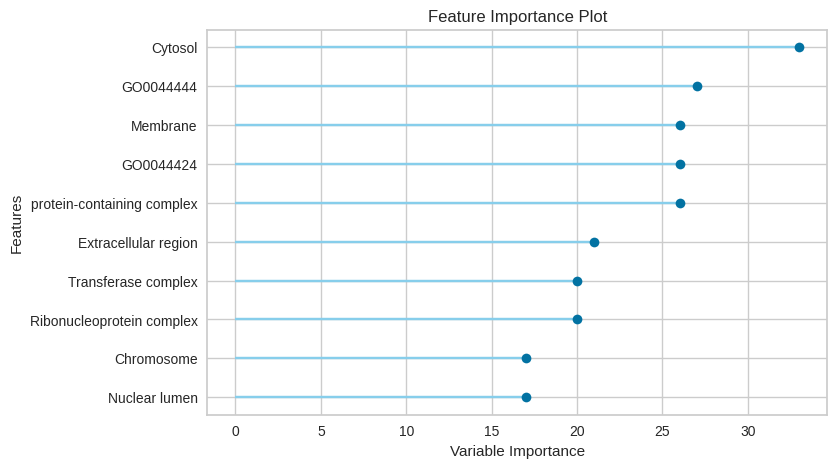

In [58]:
plot_model(estimator = tuned_lgbm, plot = 'feature')

<Figure size 800x550 with 0 Axes>

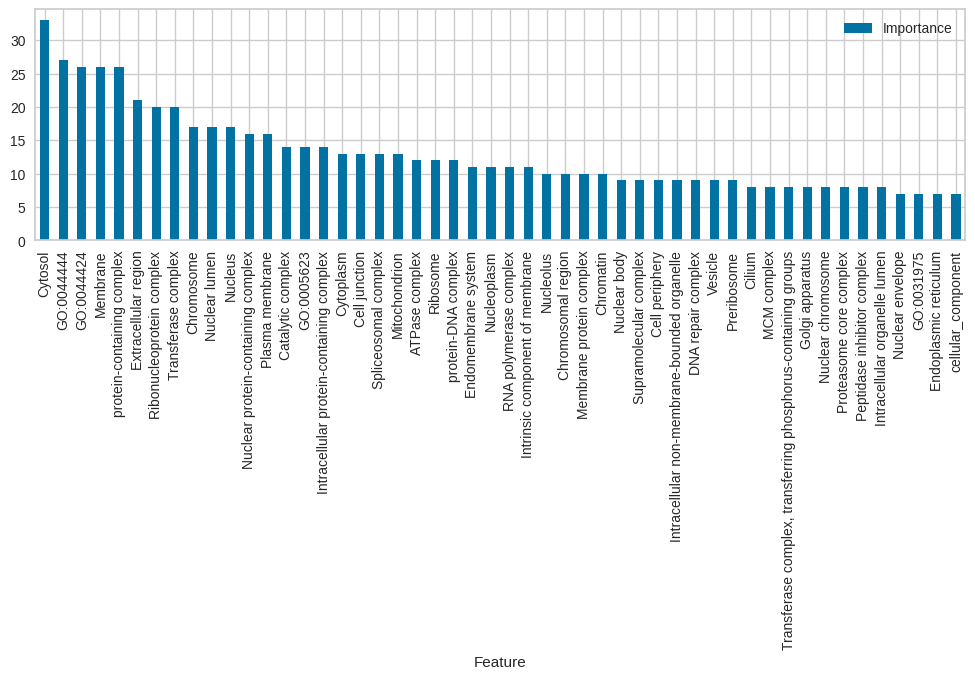

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 

In [59]:
import matplotlib.pyplot as plt
plt.tight_layout()
ax = pd.DataFrame({'Feature': get_config('X_train').columns, 'Importance' : 
                   tuned_lgbm.feature_importances_}).sort_values('Importance', ascending=False).head(50).plot.bar(x='Feature', y='Importance')
fig.tight_layout()
fig = ax.get_figure()
fig.set_size_inches(12, 3)
fig.savefig('feature_importance.png')

In [47]:
evaluate_model(tuned_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…